# Performing GMM
Now that we have our dataset, we can now perform GMM to cluster stocks based on the technical indicators.

In [1]:
tickers = ["AMZN", "TSLA", "BABA", "HD", "TM", "NKE", "MCD", "LOW", "SBUX", "JD", "PDD", "BKNG", "GM", "MELI", "TJX", "NIO", "F", "LULU", "HMC", "CMG"]

In [2]:
import sys
import os

!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


We will first perform GMM on each stock individually based on its technical indicators, with the covariance type as full

Clustering stocks using GMM

AMZN silhouette score: [0.39209531061200936, 0.21779718715453053, 0.17821085652526505, 0.22436089580385715, 0.2163086446024713, 0.2215010286285876, 0.23764734394189602, 0.1917633565525937, 0.2207503778013726, 0.22577485412747594, 0.23365713912976924, 0.2047207688378778, 0.2192345746733371]


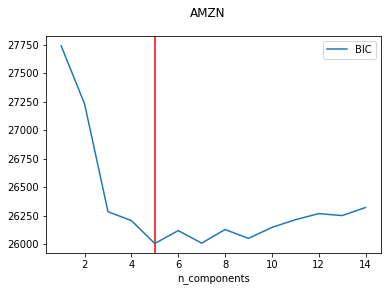

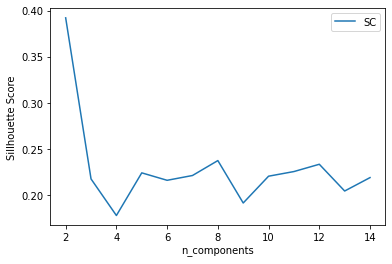


TSLA silhouette score: [0.3205220336597817, 0.2749296574363373, 0.28784206063703643, 0.2108144195176432, 0.23160692307238562, 0.22754468429184704, 0.1807279898240075, 0.16359656166463613, 0.1722752385704679, 0.15948668532930643, 0.17066199170851945, 0.13247434021584595, 0.16693772949522082]


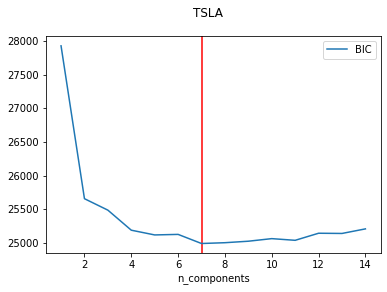

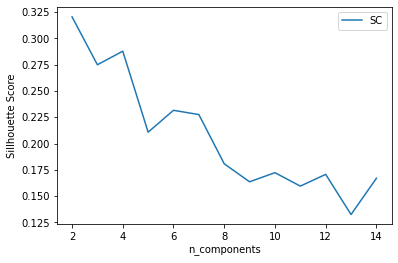


BABA silhouette score: [0.39072124564536276, 0.3015002385081046, 0.29470833438964017, 0.2898353998539837, 0.22368398689153599, 0.22902009763915251, 0.22345122487566305, 0.2228794771680306, 0.21633167989472304, 0.22416049438610713, 0.23209901055005006, 0.23543253791398, 0.2128863413529517]


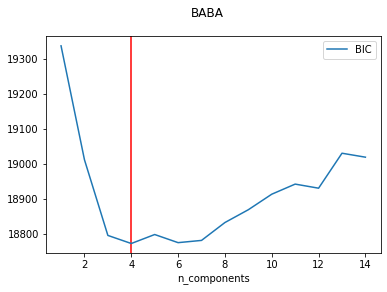

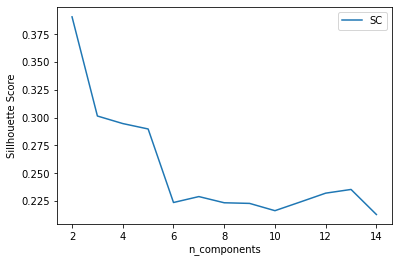


HD silhouette score: [0.2683325459386303, 0.27323732726112837, 0.23673608508402388, 0.24368151682212535, 0.21958099263651398, 0.22760973160709055, 0.1839406471808264, 0.18751938770094728, 0.17785462039864572, 0.19408429758310672, 0.19887688241035675, 0.23135432801339514, 0.24633666989143657]


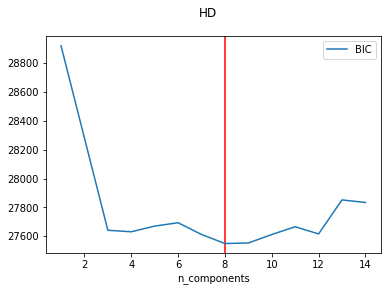

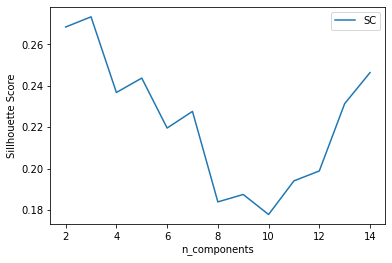


TM silhouette score: [0.2792974707871063, 0.25917234658848615, 0.2559173787846333, 0.21011582029579756, 0.1416298179156158, 0.20149719080973436, 0.19199264140108047, 0.1596913835253788, 0.12049574054617751, 0.13129663885738543, 0.09140845290428767, 0.16836267436085142, 0.15883555765924323]


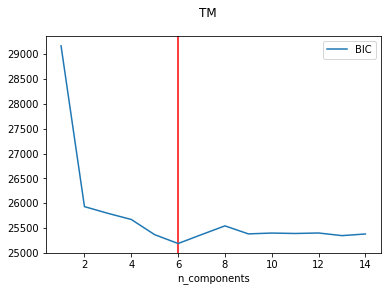

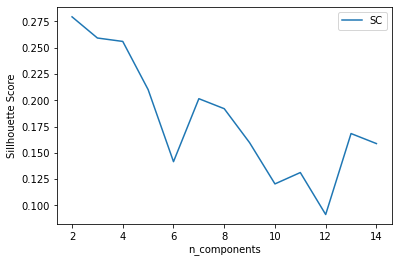


NKE silhouette score: [0.2728039004569217, 0.14630569304198945, 0.16599819028173418, 0.11106027998240713, 0.2049561330213087, 0.23551384406067072, 0.19199708983513364, 0.1575902992934912, 0.24539284040652537, 0.2220977752170403, 0.19246890897878535, 0.1972400364843814, 0.20551585828470315]


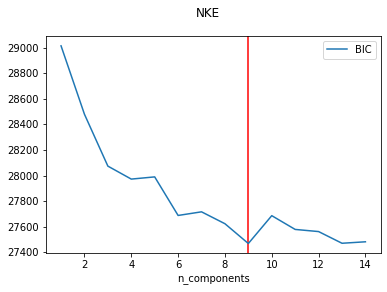

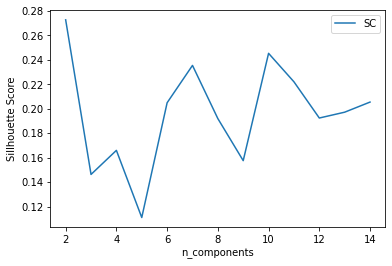


MCD silhouette score: [0.34271168225267046, 0.34374040533963485, 0.30853136409212994, 0.26092581005894827, 0.20801302739952798, 0.23121206454688997, 0.19881781883130198, 0.18935002667039647, 0.19083666634126706, 0.1791197161935402, 0.1832672774913461, 0.15985736431190767, 0.19079125032967448]


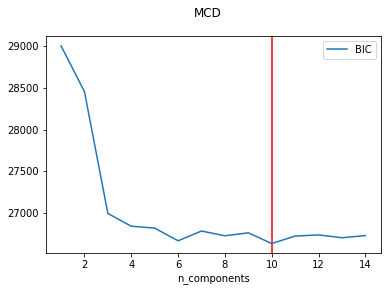

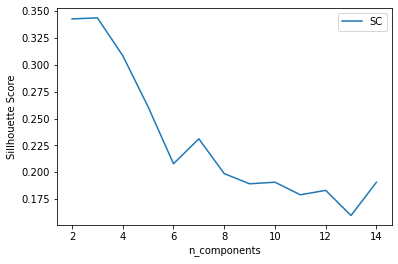


LOW silhouette score: [0.5416757603363616, 0.296866438734562, 0.22306989670403818, 0.19830203571191035, 0.20890216759951014, 0.20125927984383452, 0.21451781731766764, 0.20246762355369835, 0.176787236217567, 0.20033030139139263, 0.20314443384338376, 0.16902359935841016, 0.21820942010888872]


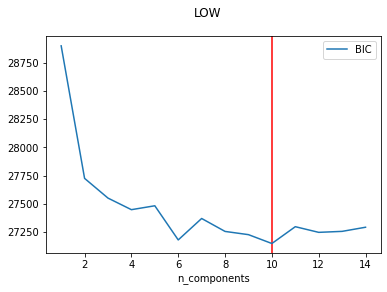

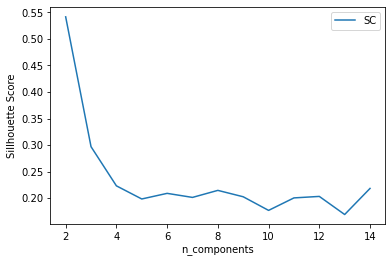


SBUX silhouette score: [0.49194269236622223, 0.30339896461893845, 0.21960321162323568, 0.2031545042271392, 0.2020201044699952, 0.22700041092417933, 0.18993503507392856, 0.1468124779857243, 0.11122106465038484, 0.11531628738895022, 0.11566026153318175, 0.13402212969128463, 0.11311777824172825]


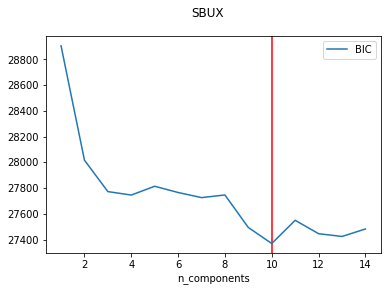

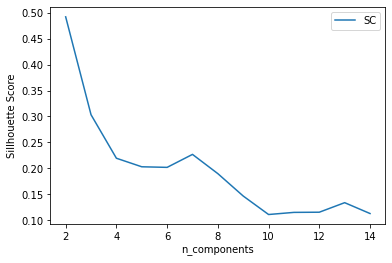


JD silhouette score: [0.31035440986728235, 0.2329610051543497, 0.22211200361970662, 0.2084645861726985, 0.21050578772535142, 0.16795794448972415, 0.21641708646440297, 0.18765558412959646, 0.1736180011418081, 0.19741970942945594, 0.19736340809057495, 0.1988728545601673, 0.19314763805641166]


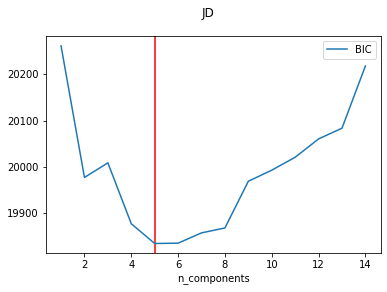

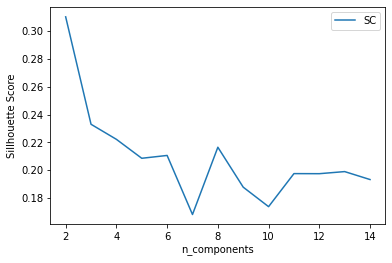


PDD silhouette score: [0.2813215065291519, 0.24133849042303993, 0.10065488997136118, 0.2137876780148909, 0.23443380359319846, 0.15122660804866672, 0.20350964557212825, 0.15557670317773242, 0.17980088061658278, 0.23877792427273506, 0.17412699261083323, 0.1715622606903466, 0.1709494913534586]


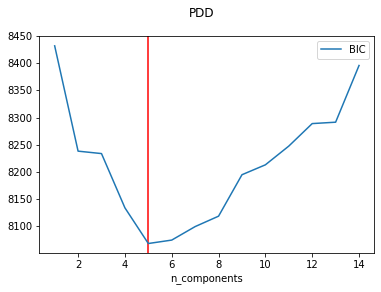

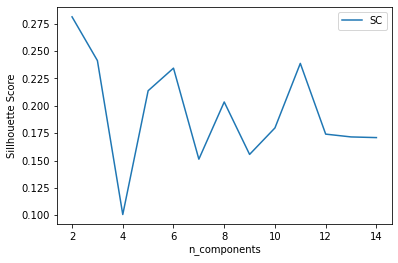


BKNG silhouette score: [0.38929841252220376, 0.2618306332070297, 0.195272405968591, 0.19358476913577533, 0.2106342881619376, 0.22696169419314594, 0.21212173356684677, 0.21463365113513086, 0.21234676098215508, 0.16004125536061858, 0.19789971764513511, 0.21262352767173612, 0.1791099676334877]


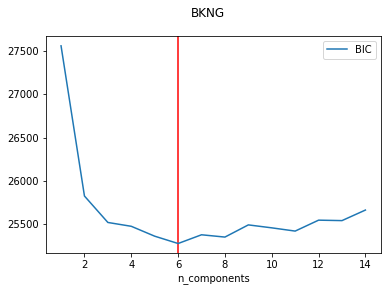

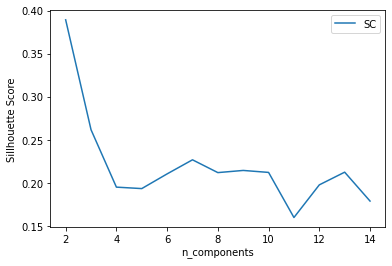


GM silhouette score: [0.4110362543156301, 0.3506194628047085, 0.17866961501706594, 0.13618776843646035, 0.13552528109981368, 0.1566886461549693, 0.1574505590533269, 0.11988484148803144, 0.14444970742755633, 0.16562122782615474, 0.15578746102677185, 0.1572683960738596, 0.17442329024004333]


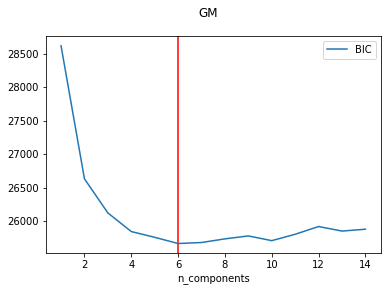

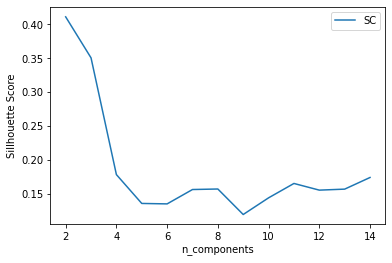


MELI silhouette score: [0.3055158524197454, 0.19574015913242088, 0.1953359911207938, 0.1368659198406135, 0.12379877310052871, 0.11244206062190075, 0.18719388914266682, 0.18903503158606522, 0.18477623696723028, 0.17843728612220736, 0.11322585483299114, 0.14846385349632424, 0.16899549485242982]


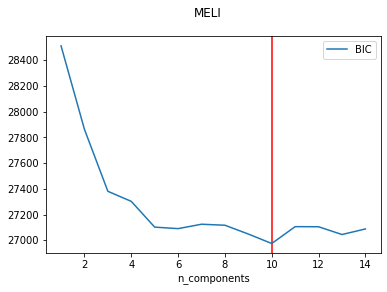

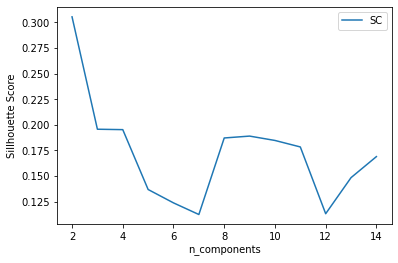


TJX silhouette score: [0.36792896338803693, 0.3255097798427704, 0.22492650425542307, 0.21012840687202938, 0.20340109913246104, 0.21551476004830367, 0.182280454304856, 0.1689025836769646, 0.17950610933023958, 0.1817529583953338, 0.17217262291068783, 0.18613273533127825, 0.1976689754156828]


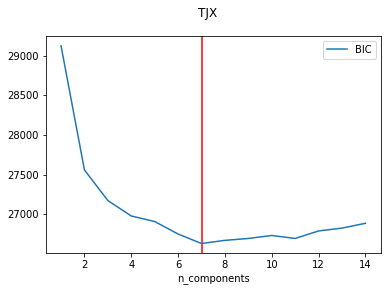

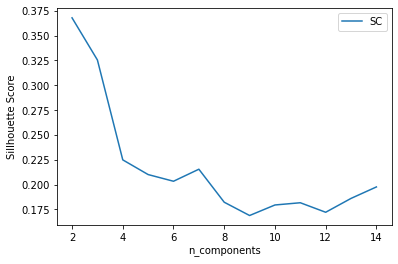


NIO silhouette score: [0.25616460378411937, 0.20949446431970284, 0.20403074296051427, 0.21094961347733185, 0.15177612457447567, 0.22207723481948766, 0.19722921286665576, 0.1793496105431314, 0.22574000724348653, 0.20899622683867958, 0.17463568385238754, 0.16935969714753188, 0.18040994880062677]


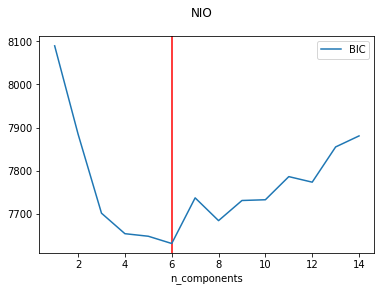

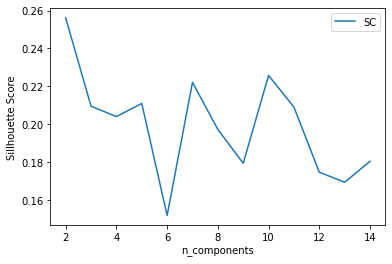


F silhouette score: [0.3876153440108453, 0.36524252376778255, 0.3000726939994323, 0.27741958371512193, 0.2738390671401339, 0.219004238157836, 0.24386981064955546, 0.20213724375348024, 0.18981070379112014, 0.1929354747711429, 0.12024399573638768, 0.18915936272240338, 0.185051534088033]


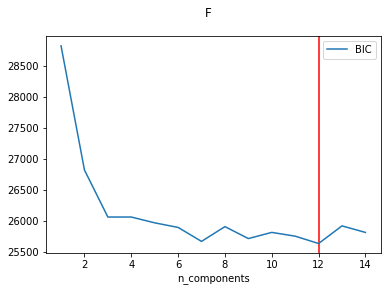

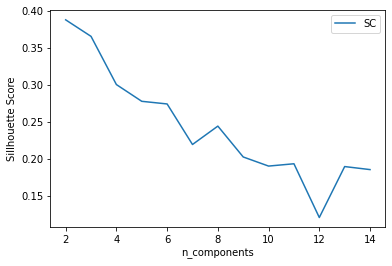


LULU silhouette score: [0.3735758761040091, 0.2843102366897373, 0.15538452274441594, 0.23478618907698498, 0.2559863766184828, 0.2218589387859542, 0.2146772290066761, 0.2252649964120584, 0.20424792497573377, 0.2245436693625402, 0.2309165191008733, 0.22367862591029, 0.20286685854077516]


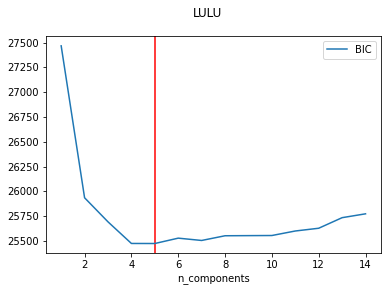

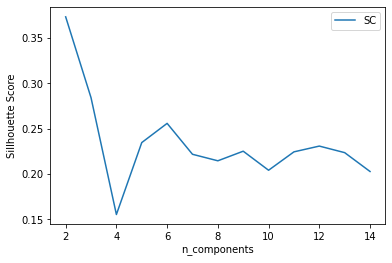


HMC silhouette score: [0.28393385960674916, 0.2611393722757524, 0.15517814212027226, 0.2143870145180364, 0.21808136647455348, 0.2318631006232687, 0.23348651940865886, 0.22323255330626926, 0.2432766348777292, 0.20123751634948683, 0.23739781728789883, 0.19734428196726042, 0.20173619338146145]


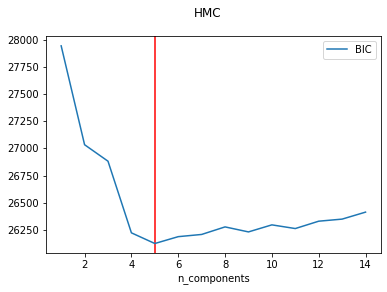

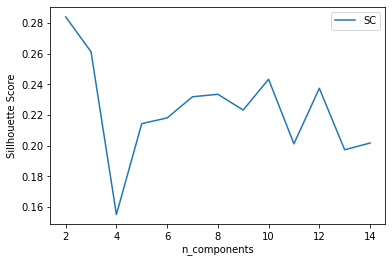


CMG silhouette score: [0.42684345472906576, 0.28162990507214364, 0.3104530951744297, 0.19076874052461798, 0.20155707575644702, 0.2221496696441322, 0.15704209127612787, 0.19363280102233507, 0.19098764410061364, 0.2268898808696448, 0.17852867416574192, 0.14175629695060848, 0.14978897922894835]


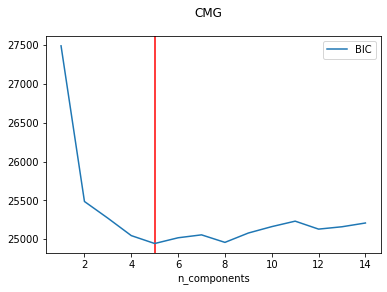

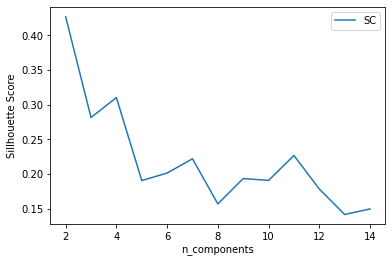

In [4]:
print("Clustering stocks using GMM")
for i in range(len(tickers)):

    # read in data from csv
    data = pd.read_csv(f'./data/{tickers[i]}.csv')

    # generate matrix with technical indicators (features) as columns
    features = data.to_numpy()[:, 6:]

    # normalize each feature
    scaler = StandardScaler()
    X = scaler.fit_transform(features)

    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    X = pca.fit_transform(X)

    newPlot = plt.figure(i)
    newPlot.suptitle(tickers[i])
    n_components = np.arange(1, features.shape[1]+1)
    gmms = [GaussianMixture(n_components=k, covariance_type='full').fit(X) for k in n_components]

    
    bics = np.array([gmm.bic(X) for gmm in gmms])
    
    minidx = np.argmin(bics)
    centroids = gmms[minidx].means_

    # calculate metrics
    silhouette_avg = [metrics.silhouette_score(X, gmms[k-1].predict(X)) for k in n_components[1:]]
    print(f"\n{tickers[i]} silhouette score: {silhouette_avg}")

    # descale centroids
    centroids = scaler.inverse_transform(pca.inverse_transform(centroids))

    # create df for centroids
    centroids_df = pd.DataFrame(centroids, columns=data.columns[6:])
    if not os.path.exists("centroids"):
        os.mkdir("centroids")
    centroids_df.to_csv(f'./centroids/{tickers[i]}_centroids.csv')

    # plot the results
    plt.axvline(x=minidx + 1, color='r')
    plt.plot(n_components, bics, label='BIC')
    plt.legend(loc='best')
    plt.xlabel('n_components')

    plt.show()

    plt.plot(n_components[1:], silhouette_avg, label='SC')
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.ylabel('Sillhouette Score')
    plt.show()
